### 手写数字识别

every layer includes forward and  backward functions 

In [3]:
import numpy as np
from collections import OrderedDict
import random

两层全连接网络实现手写数字识别

网络结构很简单，两层全连接层之后，添加relu作为非线性激活函数

> ？[非线性激活函数的作用的理解](https://zhuanlan.zhihu.com/p/25110450)
请看下图：  
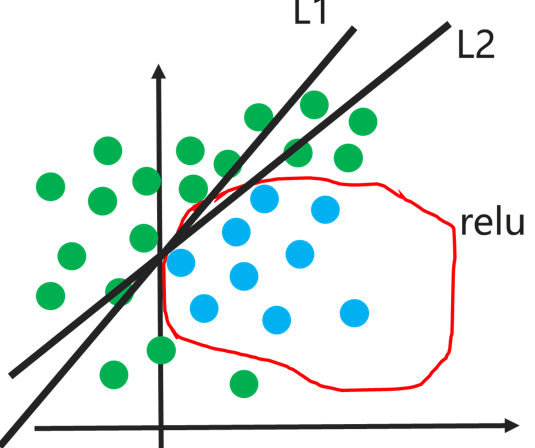  
对于一个上图的分类问题，如果采用非激活函数（也就是线性拟合）来看，不论怎么拟合都无法做到很好的2分类。究其根本，我们目的就是利用多段L进行非线性拟合，圈出一个多段的多边形进行框住2分类样本。那么获得这种非线性就是需要一些基本的激活函数（本质是[-1,1]区间上的非线性，[-1,1]是为了避免引起样本残差过大。）

###### 看下relu的效果

定义Relu层

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout * 1
        return dx

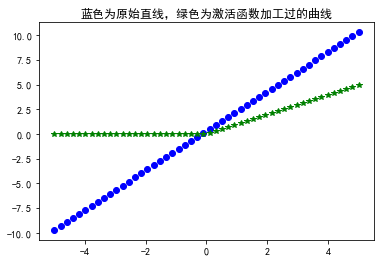

In [23]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
relu = Relu()
x_ = np.linspace(-5,5)
y_1 = 2*x_ + np.random.random(1)
plt.plot(x_, y_1, 'bo')
plt.figure
y_2 = relu.forward(x_)
plt.plot(x_,y_2, 'g*')
plt.title("蓝色为原始直线，绿色为激活函数加工过的曲线")
plt.show()

#### 全连接层

全连接层一般有几种叫法，d2lzh上叫做Affine，其他论文及文献中叫做fc（full connected）

In [3]:
# Affine定义

In [24]:
class Affine:
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        self.dW = None
        self.db = None
        self.x = None
    def forward(self,x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    def backward(self, dout):
        
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        return dx

#### Softmax 打分

In [25]:
def Softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

#### crossentrpy交叉熵

In [50]:
def CrossEntropy(y, t):
    # t one-hot 
    if y.ndim == 1:
        t.reshape(1, t.size)
        y.reshape(1, y.size)
    if t.size == y.size:
        t_mask = t.argmax(axis=1)

    batch_size = y.shape[0]
    print(batch_size)
    return -np.sum(np.log(y[np.arange(batch_size), t_mask]+ 1e-7)) / batch_size

In [51]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        #global _t
        t_ = np.argmax(t, axis=1)
        #t = t.astype('int')
    
        batch_size = y.shape[0]

        return -np.sum(np.log(y[np.arange(batch_size), t_] + 1e-7)) / batch_size

In [27]:
#### 将Softmax和crossentrpy集成成一个专属层

In [38]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    def forward(self,x,t):
        self.t = t
        self.y = Softmax(x)
        #self.loss = CrossEntropy(self.y, self.t)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = dout * (self.y - self.t)/batch_size
        return dx

In [39]:
from collections import OrderedDict

##### 定义2层网络结构，包含loss_function、predict、accuracy、gradient_computed

In [40]:
class TwoLayerNet:
    # 
    def __init__(self, input_size, hiddden_size, output_size, weight_init_std=0.01):
        self.input_size = input_size
        self.hiddden_size = hiddden_size
        self.ouput_size = output_size
    
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hiddden_size)
        self.params['b1'] = np.zeros(hiddden_size,)
        self.params['W2'] = weight_init_std* np.random.randn(hiddden_size, output_size)
        self.params['b2'] = np.zeros(output_size,)
    
        # 层
        # OrderDict使用
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    
        self.lastlayer = SoftmaxWithLoss()
    
    # 预测数据
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    # 该处即能看出layer层的forward定义的初始化参数的格式必须一致
    
    # 定义loss
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastlayer.forward(y, t)
    
    # 求出loss之后，整个模型的准确度
    def accuracy(self, x, t):
        y = self.predict(x)
        # y 是 没有经过softmax处理的数据
        y = np.argmax(y, axis=1) # 求每行的最大值
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        batch_size = float(x.shape[0])
        acc = np.sum(y==t) / batch_size
        return acc
    
    # valuate the model by using validation data
    # 求梯度
    def gradient(self,x,t):
        # forward
        self.loss(x,t)
        # backward
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
    
        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads

### 实现训练

#### 1 引入训练数据

In [41]:
from dataset.mnist import load_mnist

In [42]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [43]:
x_train.shape

(60000, 784)

In [44]:
t_train.shape

(60000, 10)

In [54]:
np.reshape(x_train, (60000, 28, 28))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [45]:
# 创建网络

In [46]:
network = TwoLayerNet(input_size=784, hiddden_size=50, output_size=10)

In [47]:
iter_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
train_loss = []
train_acc = []
test_acc = []

In [48]:
iter_per_epoch = max(train_size/batch_size, 1)

In [52]:
for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 通过误差反向传播求梯度
    grad = network.gradient(x_batch, t_batch)
    # 更新
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss.append(loss)
    
    if i % iter_per_epoch == 0:
        train_accuary = network.accuracy(x_train, t_train)
        test_accuary = network.accuracy(x_test, t_test)
        test_acc.append(test_accuary)
        train_acc.append(train_accuary)
        print(train_accuary, test_accuary)

0.08445 0.0862
0.49955 0.4993
0.7668333333333334 0.7723
0.8410333333333333 0.8474
0.8693666666666666 0.8734
0.88105 0.887
0.8899333333333334 0.8952
0.89595 0.9004
0.9002166666666667 0.9037
0.90335 0.9053
0.9065833333333333 0.9087
0.90955 0.9113
0.91015 0.9137
0.9128166666666667 0.9176
0.9147833333333333 0.9179
0.9159666666666667 0.9179
0.9180333333333334 0.9202
